In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [254]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']
IDtest

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [255]:
def detect_outliers(df,n,features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[ (df[col] < Q1-outlier_step) | 
                              (df[col] > Q3 + outlier_step) ].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items()
                            if v > n)
    
    return multiple_outliers

In [256]:
multi_outliers_index = detect_outliers(train,2,['Age','Fare','SibSp','Parch'])

In [257]:
train.shape

(891, 12)

In [258]:
train.drop(multi_outliers_index,axis=0,inplace=True)

In [259]:
train.shape

(881, 12)

In [260]:
train_len = len(train)
dataset = pd.concat(objs=[train,test],axis=0)
dataset.shape

(1299, 12)

In [261]:
train.info()
train.isnull().sum()
train.head()
train.dtypes
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 89.5+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


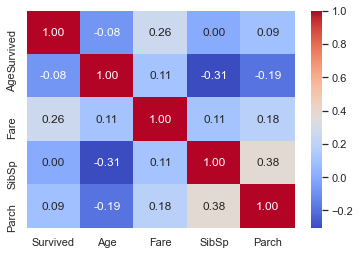

In [262]:
g = sns.heatmap(train[['Survived','Age','Fare','SibSp','Parch']].corr(),
               annot=True,fmt='.2f',cmap='coolwarm')

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


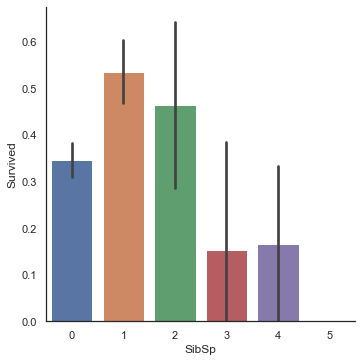

In [263]:
g = sns.factorplot(data=train,x='SibSp',y='Survived',kind='bar')
#g.despine(left=True)

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


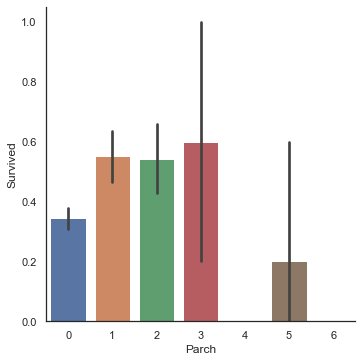

In [264]:
g = sns.factorplot(data=train,x='Parch',y='Survived',kind='bar')

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


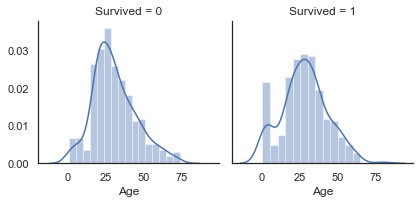

In [265]:
g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

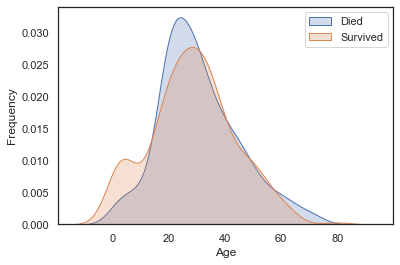

In [266]:
g = sns.kdeplot(train['Age'][train['Survived']==0],shade=True)
g = sns.kdeplot(train['Age'][train['Survived']==1],shade=True)
g.set_ylabel('Frequency')
g.legend(['Died','Survived'])

In [267]:
dataset['Fare'].isnull().sum()

1

In [268]:
dataset['Fare'].fillna(dataset['Fare'].median(),inplace=True)

In [269]:
dataset['Fare'].isnull().sum()

0

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


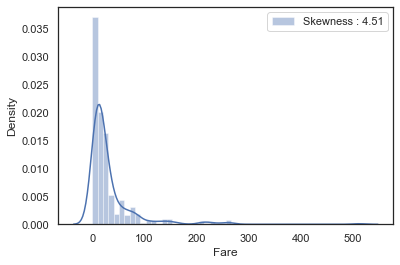

In [270]:
g = sns.distplot(dataset['Fare'],label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

In [271]:
dataset['Fare'].head(2)

0     7.2500
1    71.2833
Name: Fare, dtype: float64

In [272]:
dataset['Fare'] = dataset['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

In [273]:
dataset['Fare'].head(2)

0    1.981001
1    4.266662
Name: Fare, dtype: float64

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


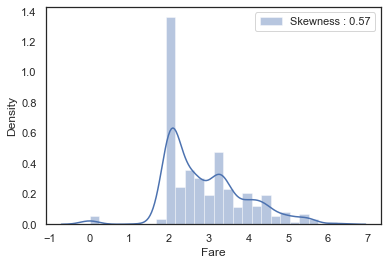

In [274]:
g = sns.distplot(dataset['Fare'],label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

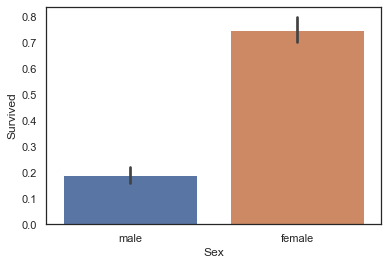

In [275]:
g = sns.barplot(data=train,x='Sex',y='Survived')

In [276]:
train.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.747573
male,0.190559


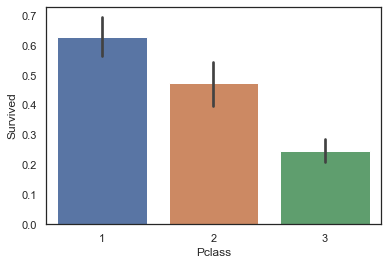

In [277]:
g = sns.barplot(data=train,x='Pclass',y='Survived')

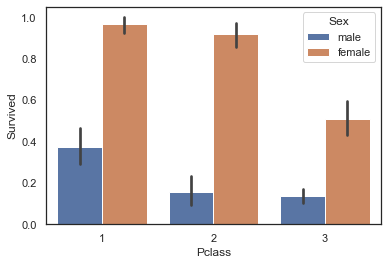

In [278]:
g = sns.barplot(data=train,x='Pclass',y='Survived',hue='Sex')

In [279]:
dataset['Embarked'].isna().sum()

2

In [280]:
dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)

In [281]:
dataset['Embarked'].isna().sum()

0

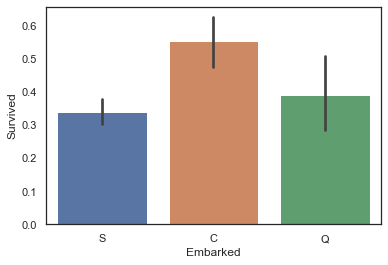

In [282]:
g = sns.barplot(data=train,x='Embarked',y='Survived')

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


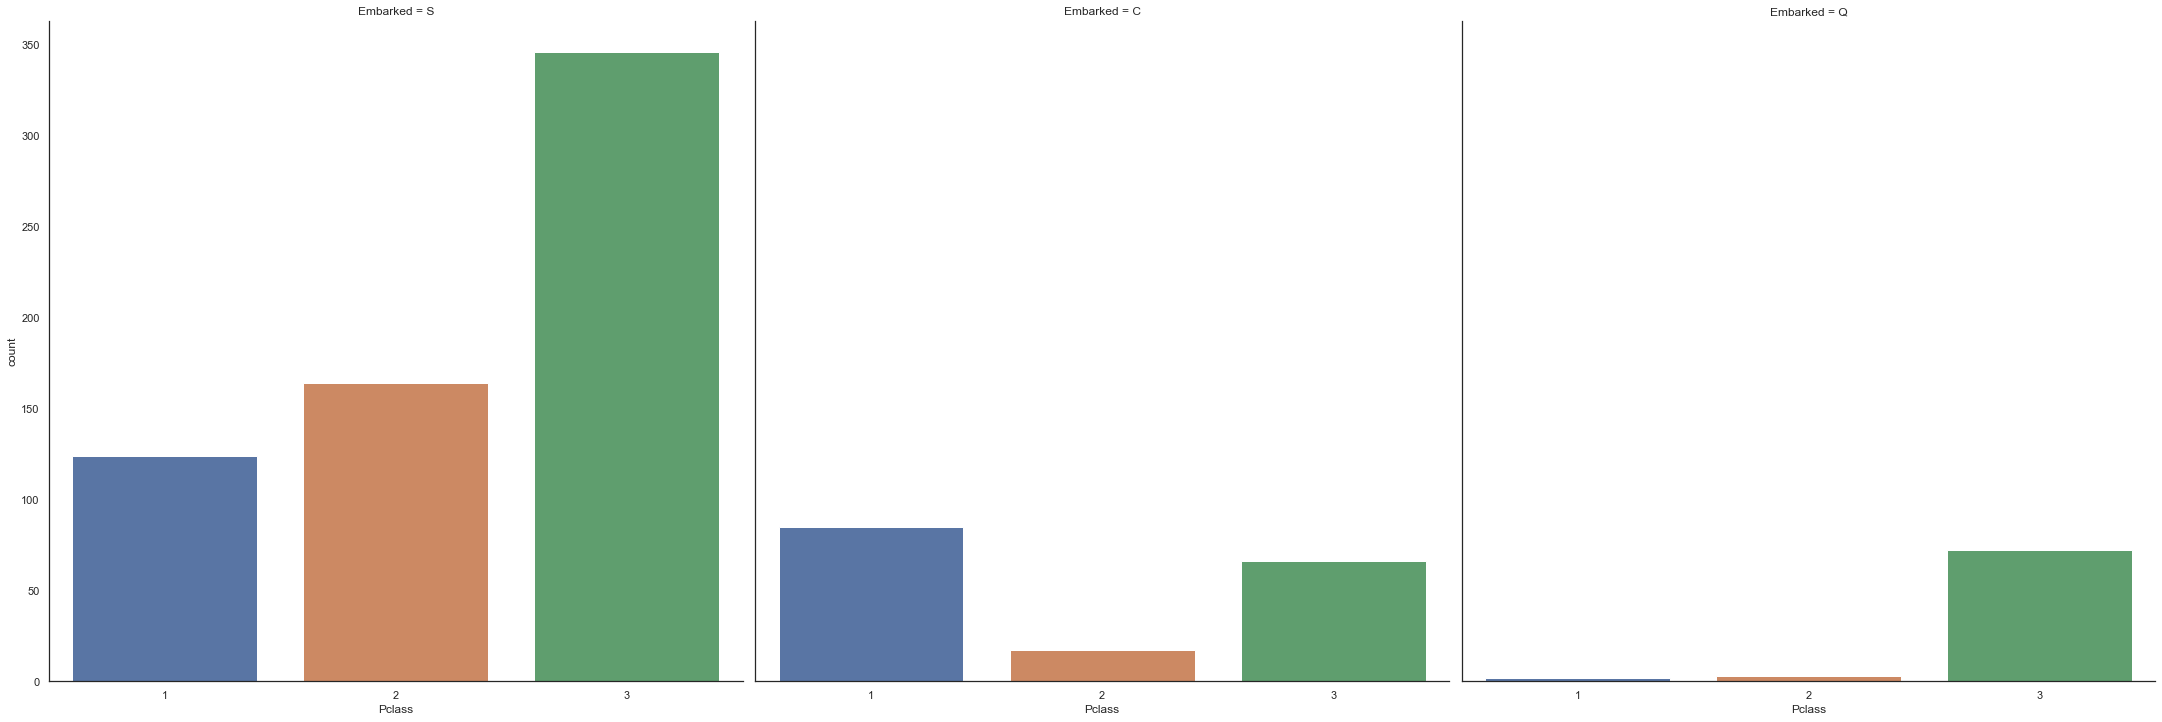

In [283]:
g = sns.factorplot(data=train,x='Pclass',kind='count',col='Embarked',size=10)

In [284]:
dataset.corr()['Age']

PassengerId    0.026685
Survived      -0.076867
Pclass        -0.411777
Age            1.000000
SibSp         -0.242127
Parch         -0.148784
Fare           0.200555
Name: Age, dtype: float64

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

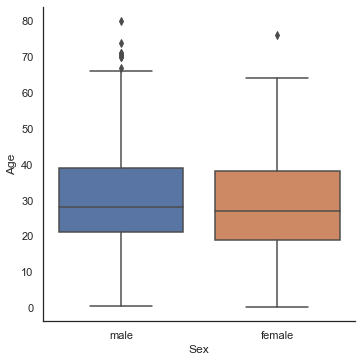

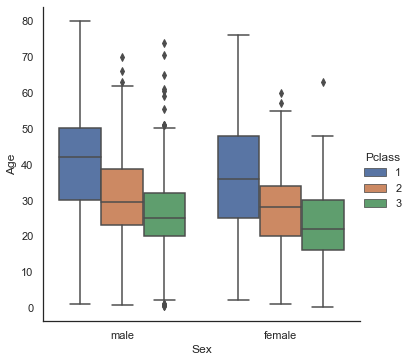

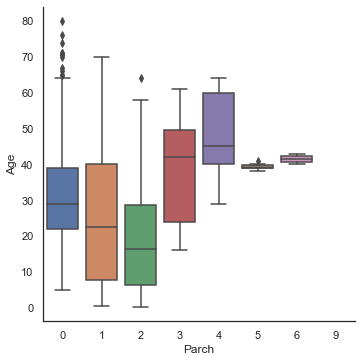

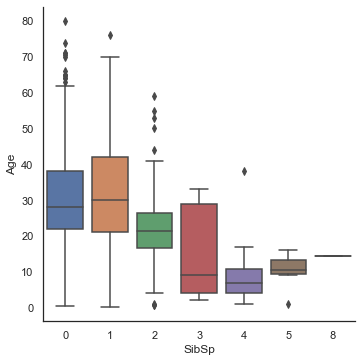

In [285]:
g = sns.factorplot(data=dataset,x='Sex',y='Age',kind='box')
g = sns.factorplot(data=dataset,x='Sex',y='Age',kind='box',hue='Pclass')
g = sns.factorplot(data=dataset,x='Parch',y='Age',kind='box')
g = sns.factorplot(data=dataset,x='SibSp',y='Age',kind='box')

In [286]:
dataset['Sex'].head(3)

0      male
1    female
2    female
Name: Sex, dtype: object

In [287]:
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female':1})

In [288]:
dataset['Sex'].head(3)

0    0
1    1
2    1
Name: Sex, dtype: int64

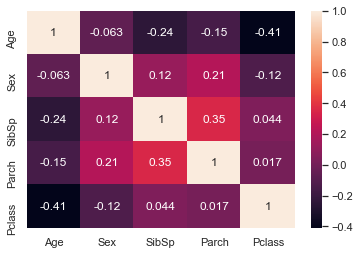

In [289]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),annot=True)

# fillna가 제대로 안됐던 이유
- train,test를 합친 dataset의 index를 reset 하지 않아서 index 중복이 발생함.

In [297]:
dataset['Age'].isnull().sum()

0

In [291]:
dataset.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,2.085672,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,4.690430,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,2.085672,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",0,NaN,1,1,2668,3.107198,NaN,C


In [294]:
dataset = dataset.reset_index()

In [295]:
dataset.tail()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1294,413,1305,NaN,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,2.085672,NaN,S
1295,414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,4.690430,C105,C
1296,415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,S
1297,416,1308,NaN,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,2.085672,NaN,S
1298,417,1309,NaN,3,"Peter, Master. Michael J",0,NaN,1,1,2668,3.107198,NaN,C


In [296]:
index_NaN_age = list(dataset[dataset["Age"].isnull()].index)
age_med = dataset['Age'].median()

for i in index_NaN_age :
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if pd.isnull(age_pred):
        print('age_pred is null','age_med : ',age_med)
        dataset.iloc[i,dataset.columns.get_loc('Age')] = age_med
    else:
        print('index : ',i,'age_pred : ',age_pred)
        dataset.iloc[i,dataset.columns.get_loc('Age')] = age_pred
        print('삽입 후 : ',dataset.iloc[i]['Age'])

index :  5 age_pred :  25.0
삽입 후 :  25.0
index :  17 age_pred :  30.0
삽입 후 :  30.0
index :  19 age_pred :  25.0
삽입 후 :  25.0
index :  26 age_pred :  25.0
삽입 후 :  25.0
index :  27 age_pred :  25.0
삽입 후 :  25.0
index :  28 age_pred :  25.0
삽입 후 :  25.0
index :  30 age_pred :  38.0
삽입 후 :  38.0
index :  31 age_pred :  25.0
삽입 후 :  25.0
index :  35 age_pred :  25.0
삽입 후 :  25.0
index :  41 age_pred :  25.0
삽입 후 :  25.0
index :  44 age_pred :  25.0
삽입 후 :  25.0
index :  45 age_pred :  25.0
삽입 후 :  25.0
index :  46 age_pred :  25.0
삽입 후 :  25.0
index :  47 age_pred :  23.0
삽입 후 :  23.0
index :  54 age_pred :  39.0
삽입 후 :  39.0
index :  63 age_pred :  39.0
삽입 후 :  39.0
index :  64 age_pred :  16.0
삽입 후 :  16.0
index :  75 age_pred :  25.0
삽입 후 :  25.0
index :  76 age_pred :  25.0
삽입 후 :  25.0
index :  81 age_pred :  25.0
삽입 후 :  25.0
index :  86 age_pred :  25.0
삽입 후 :  25.0
index :  93 age_pred :  25.0
삽입 후 :  25.0
index :  99 age_pred :  25.0
삽입 후 :  25.0
index :  105 age_pred :  25.0
삽입 후 

삽입 후 :  25.0
index :  1149 age_pred :  25.0
삽입 후 :  25.0
index :  1152 age_pred :  25.0
삽입 후 :  25.0
index :  1154 age_pred :  25.0
삽입 후 :  25.0
index :  1155 age_pred :  25.0
삽입 후 :  25.0
index :  1163 age_pred :  25.0
삽입 후 :  25.0
index :  1167 age_pred :  25.0
삽입 후 :  25.0
index :  1169 age_pred :  25.0
삽입 후 :  25.0
index :  1170 age_pred :  25.0
삽입 후 :  25.0
index :  1171 age_pred :  39.0
삽입 후 :  39.0
index :  1173 age_pred :  25.0
삽입 후 :  25.0
index :  1178 age_pred :  23.0
삽입 후 :  23.0
index :  1182 age_pred :  30.0
삽입 후 :  30.0
index :  1185 age_pred :  25.0
삽입 후 :  25.0
index :  1193 age_pred :  25.0
삽입 후 :  25.0
index :  1213 age_pred :  25.0
삽입 후 :  25.0
index :  1220 age_pred :  25.0
삽입 후 :  25.0
age_pred is null age_med :  28.0
index :  1225 age_pred :  16.0
삽입 후 :  16.0
index :  1238 age_pred :  25.0
삽입 후 :  25.0
index :  1239 age_pred :  25.0
삽입 후 :  25.0
index :  1246 age_pred :  28.0
삽입 후 :  28.0
index :  1247 age_pred :  25.0
삽입 후 :  25.0
index :  1261 age_pred :  25.0

In [251]:
dataset.shape

(1299, 12)

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


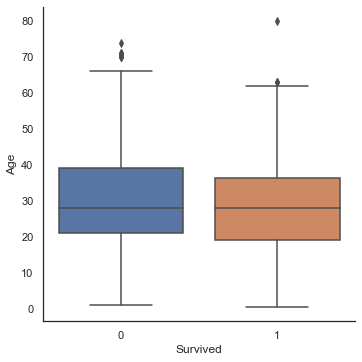

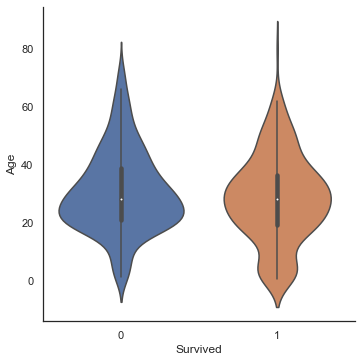

In [971]:
g = sns.factorplot(data=train,x='Survived',y='Age',kind='box')
g = sns.factorplot(data=train,x='Survived',y='Age',kind='violin')

In [972]:
dataset['Title'] = [ name.split(',')[1].split('.')[0].strip() for name in dataset['Name'] ]


In [973]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

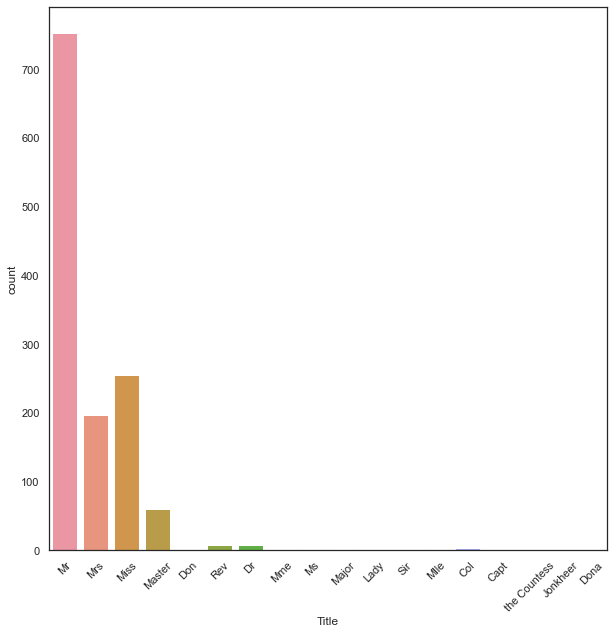

In [974]:
plt.figure(figsize=(10,10))
g = sns.countplot(data=dataset,x='Title')
g = plt.setp(g.get_xticklabels(),rotation=45)

In [975]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [976]:
dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare',inplace=True)

In [977]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Mme', 'Ms', 'Mlle'],
      dtype=object)

In [978]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})

In [979]:
dataset["Title"] = dataset["Title"].astype(int)

In [980]:
dataset['Title'].unique()

array([2, 1, 0, 3])

C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

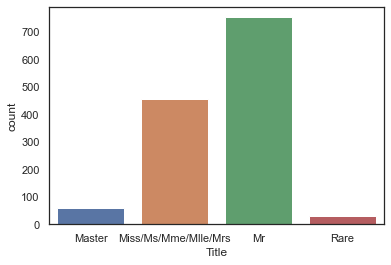

In [981]:
g = sns.countplot(dataset['Title'])
g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


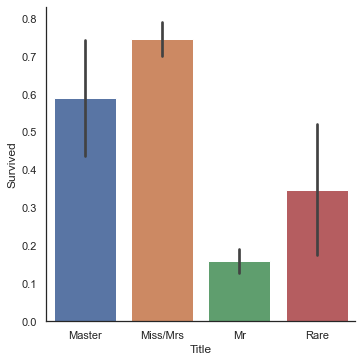

In [982]:
g = sns.factorplot(data=dataset,x='Title',y='Survived',kind='bar')
g.set_xticklabels(['Master','Miss/Mrs','Mr','Rare'])

In [983]:
dataset.drop('Name',axis=1,inplace=True)

In [984]:
dataset.shape

(1299, 12)

In [985]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [986]:
dataset.shape

(1299, 13)

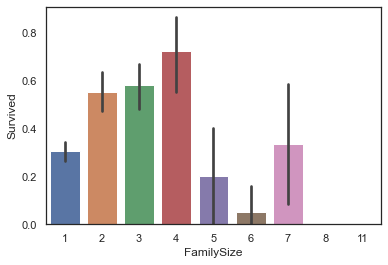

In [987]:
g = sns.barplot(data=dataset,x='FamilySize',y='Survived')

In [988]:
dataset['Single'] = dataset['FamilySize'].map(lambda v : 1 if v == 1 else 0)
dataset['SmallF'] = dataset['FamilySize'].map(lambda v : 1 if v == 2 else 0)
dataset['MedF'] = dataset['FamilySize'].map(lambda v : 1 if 3 <= v <= 4  else 0)
dataset['LargeF'] = dataset['FamilySize'].map(lambda v : 1 if v >= 5 else 0)

In [989]:
dataset.shape

(1299, 17)

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

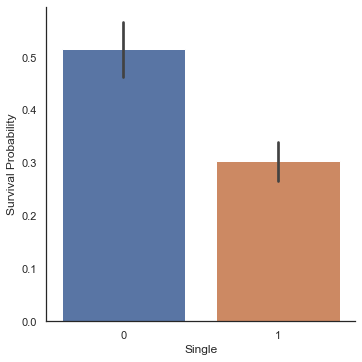

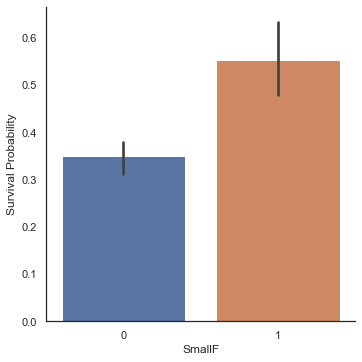

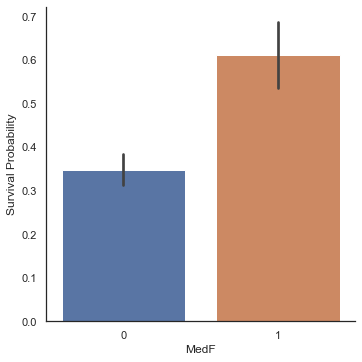

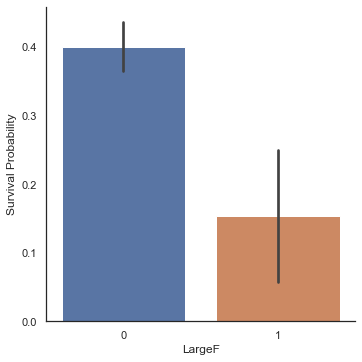

In [990]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [991]:
dataset = pd.get_dummies(dataset,columns=['Title'])
dataset = pd.get_dummies(dataset,columns=['Embarked'],prefix='Em')


In [992]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [993]:
dataset['Cabin'] = pd.Series( 'X' if pd.isnull(cabin) else cabin[0] for cabin in dataset['Cabin'])

In [994]:
dataset['Cabin'].unique() , dataset['Cabin'].isnull().sum()

(array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object), 0)

C:\Users\admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


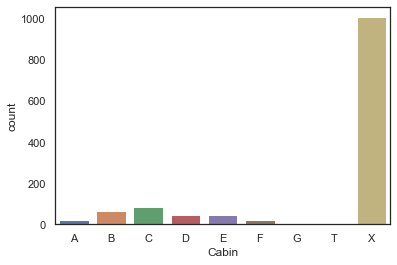

In [995]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


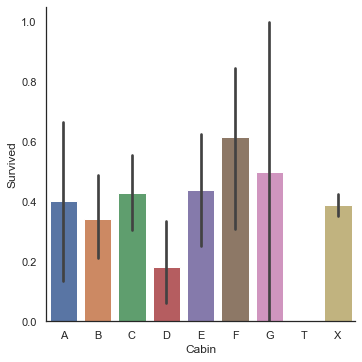

In [996]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])


In [997]:
dataset = pd.get_dummies(dataset,columns=['Cabin'])

In [998]:
dataset.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1


In [1013]:
ticket_prefix = []
for tstr in dataset['Ticket']:
    if tstr.isdigit():
        ticket_prefix.append('X')
    else:
        ticket_prefix.append(tstr.replace('/','').replace('.','').strip().split(' ')[0])        

In [1014]:
dataset['Ticket'] = ticket_prefix

In [1015]:
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [1016]:
dataset = pd.get_dummies(dataset,columns=['Ticket'],prefix='T')

In [1024]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
pd.get_dummies(dataset,columns=['Pclass'],prefix='Pc')

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,1,0.0,0,22.0,1,0,1.981001,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,1,38.0,1,0,4.266662,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,3,1.0,1,26.0,0,0,2.070022,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1.0,1,35.0,1,0,3.972177,2,0,1,...,0,0,0,0,0,0,1,1,0,0
4,5,0.0,0,35.0,0,0,2.085672,1,1,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,0,NaN,0,0,2.085672,1,1,0,...,0,0,0,0,0,0,0,0,0,1
414,1306,NaN,1,39.0,0,0,4.690430,1,1,0,...,0,0,0,0,0,0,0,1,0,0
415,1307,NaN,0,38.5,0,0,1.981001,1,1,0,...,0,0,0,0,0,0,0,0,0,1
416,1308,NaN,0,NaN,0,0,2.085672,1,1,0,...,0,0,0,0,0,0,1,0,0,1


In [1025]:
dataset.drop('PassengerId',axis=1,inplace=True)

In [1026]:
dataset.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Single,SmallF,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,0.0,3,0,22.0,1,0,1.981001,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,1,38.0,1,0,4.266662,2,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3,1,26.0,0,0,2.070022,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,1,1,35.0,1,0,3.972177,2,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0.0,3,0,35.0,0,0,2.085672,1,1,0,...,0,0,0,0,0,0,0,0,0,1
